In [234]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
## Loading the dataset
path='/content/drive/My Drive/Company Stock and Investment.csv'
df=pd.read_csv(path)

In [236]:
df.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [237]:
df=df.drop(['Oil Investments','Gold Investments','Comp Stock'],axis=1)
df

,Date,Other sharesInvestments
0,31-12-2009,0.006848
1,04-01-2010,-0.004609
2,05-01-2010,0.005900
3,06-01-2010,-0.018116
4,07-01-2010,-0.017013
...,...,...
1979,09-11-2017,-0.003310
1980,10-11-2017,-0.003348
1981,13-11-2017,0.003395
1982,14-11-2017,0.006793


In [238]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.set_index('Date', inplace=True)

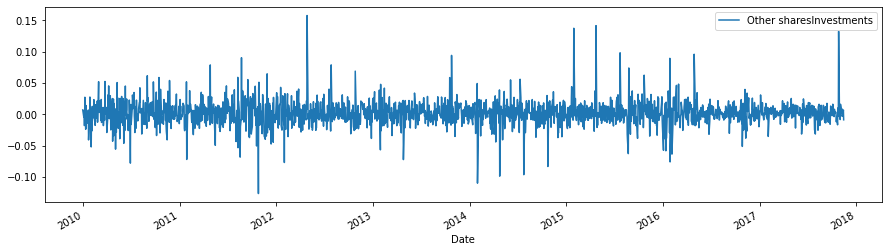

In [239]:
df.plot(figsize=(15,4))

In [240]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [241]:
print(df)

[[0.46973236]
 [0.42939579]
 [0.46639615]
 ...
 [0.45757501]
 [0.46953863]
 [0.41418861]]


In [242]:
##splitting dataset into train and test split
training_size=int(len(df)*0.76)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [243]:
training_size,test_size

(1507, 477)

In [244]:
train_data

array([[0.46973236],
       [0.42939579],
       [0.46639615],
       ...,
       [0.43841771],
       [0.44854342],
       [0.44079583]])

In [245]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----29 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [246]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [247]:
print(X_train.shape), print(y_train.shape)

(1476, 30)
(1476,)


(None, None)

In [248]:
print(X_test.shape), print(ytest.shape)

(446, 30)
(446,)


(None, None)

In [249]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [250]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [251]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [252]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 30, 50)            10400     
_________________________________________________________________
lstm_19 (LSTM)               (None, 30, 50)            20200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [253]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
24/24 [==============================] - 1s 42ms/step - loss: 0.0275 - val_loss: 0.0065
Epoch 2/200
24/24 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0027
Epoch 3/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 4/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 5/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 6/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 7/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 8/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 9/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 10/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 

In [254]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [255]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [256]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(ytest,test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(ytest,test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print('RMSE: '+str(rmse))

MSE: 0.2060491854000133
MAE: 0.4511092687333853
RMSE: 0.45392640967453446


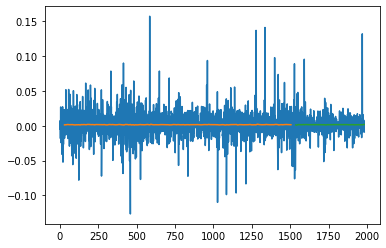

In [257]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [258]:
len(test_data)

477

In [259]:
x_input=test_data[447:].reshape(1,-1)
x_input.shape

(1, 30)

In [260]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [261]:
temp_input

[0.5017841399544866,
 0.47696034640061225,
 0.45063992946770765,
 0.43215828428618785,
 0.47344177331993487,
 0.4666067147439691,
 0.45269369322945396,
 0.4575591636245557,
 0.4553845092510822,
 0.40330232619647305,
 0.40893203819641966,
 0.4324195567266309,
 0.38612595176535003,
 0.4806021127042724,
 0.4348360204900573,
 0.4438864305090724,
 0.91094703429374,
 0.47728345486778423,
 0.42796959147634434,
 0.4405267692923368,
 0.41544511496515496,
 0.5015461048753378,
 0.47431966674638254,
 0.45350918025757725,
 0.4760613175378238,
 0.4339689958112332,
 0.4338366555178501,
 0.45757501432160824,
 0.4695386324722745,
 0.41418860746535296]

In [262]:
# demonstrate prediction for next 2 years
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<775):
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.45236212]
31
1 day input [0.47696035 0.45063993 0.43215828 0.47344177 0.46660671 0.45269369
 0.45755916 0.45538451 0.40330233 0.40893204 0.43241956 0.38612595
 0.48060211 0.43483602 0.44388643 0.91094703 0.47728345 0.42796959
 0.44052677 0.41544511 0.5015461  0.47431967 0.45350918 0.47606132
 0.433969   0.43383666 0.45757501 0.46953863 0.41418861 0.45236212]
1 day output [[0.4522576]]
2 day input [0.45063993 0.43215828 0.47344177 0.46660671 0.45269369 0.45755916
 0.45538451 0.40330233 0.40893204 0.43241956 0.38612595 0.48060211
 0.43483602 0.44388643 0.91094703 0.47728345 0.42796959 0.44052677
 0.41544511 0.5015461  0.47431967 0.45350918 0.47606132 0.433969
 0.43383666 0.45757501 0.46953863 0.41418861 0.45236212 0.4522576 ]
2 day output [[0.45213786]]
3 day input [0.43215828 0.47344177 0.46660671 0.45269369 0.45755916 0.45538451
 0.40330233 0.40893204 0.43241956 0.38612595 0.48060211 0.43483602
 0.44388643 0.91094703 0.47728345 0.42796959 0.44052677 0.41544511
 0.5015461  0.47431967

In [263]:
day_new=np.arange(1,30)
day_pred=np.arange(31,806)

In [264]:
len(df)

1984

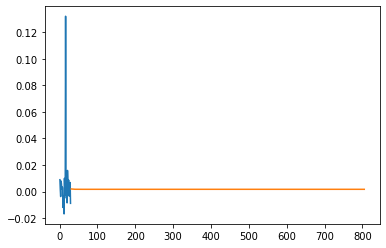

In [265]:
plt.plot(day_new,scaler.inverse_transform(df[1955:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

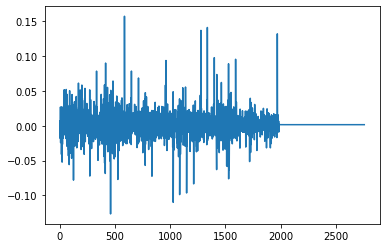

In [266]:
df3=df.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
